In [27]:
import re
from abc import *
from typing import *
import numpy as np
import scipy as sp
import networkx as nx
import mne
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.utils import shuffle
from typing import List, Tuple
from sklearn.model_selection import train_test_split
from nodestimation.learning.estimation import collect_statistic, \
    compute_importance, collect_cross_statistic, make_selection_map, \
    select, separate_datasets, selected_statistic, choose_best, selected_data, make_feature_selection
from nodestimation.processing.features import prepare_features
from nodestimation.project import find_subject_dir, conditions_unique_code
from nodestimation.pipeline import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import nilearn.plotting as nplt
from nodestimation.project.actions import read
import nodestimation as nd
from nodestimation.learning.modification import append_series, promote
import nodestimation.learning.modification as lmd
from nodestimation.project.subject import Subject
from sklearn.preprocessing import *
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib as mpl
from nodestimation.learning.selection import SubjectsStatistic
from scipy.stats import wilcoxon
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from scipy.fftpack import fftfreq, irfft, rfft
from scipy.fftpack import fftfreq, irfft, rfft

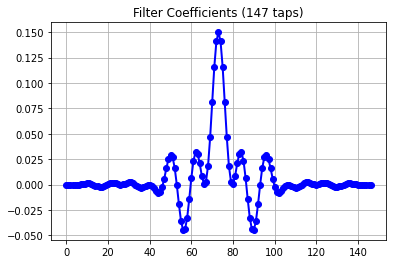

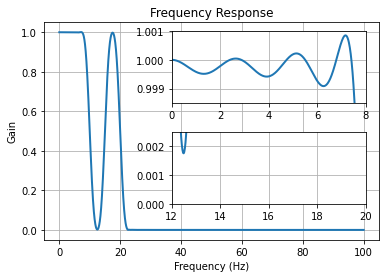

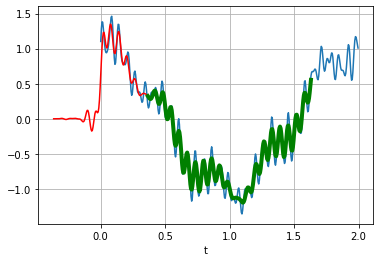

In [57]:
from numpy import cos, sin, pi, absolute, arange
from scipy.signal import kaiserord, lfilter, firwin, freqz
from pylab import figure, clf, plot, xlabel, ylabel, xlim, ylim, title, grid, axes, show


#------------------------------------------------
# Create a signal for demonstration.
#------------------------------------------------

sample_rate = 200.0
nsamples = 400
t = arange(nsamples) / sample_rate
x = cos(2*pi*0.5*t) + 0.2*sin(2*pi*2.5*t+0.1) + \
        0.2*sin(2*pi*15.3*t) + 0.1*sin(2*pi*16.7*t + 0.1) + \
            0.1*sin(2*pi*23.45*t+.8)


#------------------------------------------------
# Create a FIR filter and apply it to x.
#------------------------------------------------

# The Nyquist rate of the signal.
nyq_rate = sample_rate / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, [10/nyq_rate, 15/nyq_rate, 20/nyq_rate], window=('kaiser', beta))
# taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))
# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

#------------------------------------------------
# Plot the FIR filter coefficients.
#------------------------------------------------

figure(1)
plot(taps, 'bo-', linewidth=2)
title('Filter Coefficients (%d taps)' % N)
grid(True)

#------------------------------------------------
# Plot the magnitude response of the filter.
#------------------------------------------------

figure(2)
clf()
w, h = freqz(taps, worN=8000)
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlabel('Frequency (Hz)')
ylabel('Gain')
title('Frequency Response')
ylim(-0.05, 1.05)
grid(True)

# Upper inset plot.
ax1 = axes([0.42, 0.6, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(0,8.0)
ylim(0.9985, 1.001)
grid(True)

# Lower inset plot
ax2 = axes([0.42, 0.25, .45, .25])
plot((w/pi)*nyq_rate, absolute(h), linewidth=2)
xlim(12.0, 20.0)
ylim(0.0, 0.0025)
grid(True)

#------------------------------------------------
# Plot the original and filtered signals.
#------------------------------------------------

# The phase delay of the filtered signal.
delay = 0.5 * (N-1) / sample_rate

figure(3)
# Plot the original signal.
plot(t, x)
# Plot the filtered signal, shifted to compensate for the phase delay.
plot(t-delay, filtered_x, 'r-')
# Plot just the "good" part of the filtered signal.  The first N-1
# samples are "corrupted" by the initial conditions.
plot(t[N-1:]-delay, filtered_x[N-1:], 'g', linewidth=4)

xlabel('t')
grid(True)

show()

In [ ]:
feat = read['feat']('./Source/Subjects/M2S2_nodes_estimation_pipeline_file_features_computation_feat_9ad7cf8ab192efaef49a13ec753b04f2.pkl')

feat['30-70Hz']['envelope']

In [ ]:
subjects = pipeline(
    methods=['wpli', 'envelope'],
    freq_bands=[(0.5, 4), (4, 7), (7, 14), (14, 30), (30, 70)],
    centrality_metrics=['eigen', 'close', 'between']
)
for subject in subjects:
    print(subject.dataset['between'].head)
print(len(subjects))

In [33]:
#     s2 = subject.dataset['4-7Hz_imcoh']
#     print(s1.corr(s2))

stat1 = SubjectsStatistic(subjects, 'resected', centrality_metric='eigen')
stat2 = SubjectsStatistic(subjects, 'resected', centrality_metric='close')
# stat3 = SubjectsStatistic(subjects, 'resected', centrality_metric='between')

In [10]:
print(stat1.datasets['true'].shape)
print(stat1.datasets['false'].shape)

(42, 11)
(2358, 11)


In [ ]:
test11 = stat1.test(state='resampled')
test12 = stat1.test(state='reflected')
test21 = stat2.test(state='resampled')
test22 = stat2.test(state='reflected')
test11_samples, test12_samples, test21_samples, test22_samples = list(), list(), list(), list()
for feature in test11.result:
    test11_samples.append(test11.result[feature][1])
    test12_samples.append(test12.result[feature][1])
    test21_samples.append(test21.result[feature][1])
    test22_samples.append(test22.result[feature][1])

test_samples = np.array([
    np.array(test11_samples),
    np.array(test12_samples),
    np.array(test21_samples),
    np.array(test22_samples)
])

df = pd.DataFrame(test_samples, columns=list(test11.result.keys()), index=[
    'resampled, eigen', 'reflected, eigen', 'resampled, close', 'reflected, close'
]).T
print(df)

In [95]:
test11 = stat1.test(state='resampled', test='mannwhitneyu')
test12 = stat1.test(state='reflected', test='mannwhitneyu')
test21 = stat2.test(state='resampled', test='mannwhitneyu')
test22 = stat2.test(state='reflected', test='mannwhitneyu')
test11_samples, test12_samples, test21_samples, test22_samples = list(), list(), list(), list()
for feature in test11.result:
    test11_samples.append(test11.result[feature][1])
    test12_samples.append(test12.result[feature][1])
    test21_samples.append(test21.result[feature][1])
    test22_samples.append(test22.result[feature][1])

test_samples = np.array([
    np.array(test11_samples),
    np.array(test12_samples),
    np.array(test21_samples),
    np.array(test22_samples)
])

df = pd.DataFrame(test_samples, columns=list(test11.result.keys()), index=[
    'resampled, eigen', 'reflected, eigen', 'resampled, close', 'reflected, close'
]).T
print(df)

              resampled, eigen  reflected, eigen  resampled, close  \
0.5-4Hz_wpli          0.152841          0.255418          0.161444   
0.5-4Hz_psd           0.035026          0.341987          0.039382   
4-7Hz_wpli            0.003591          0.000650          0.189108   
4-7Hz_psd             0.203974          0.466136          0.209080   
7-14Hz_wpli           0.154963          0.037884          0.191538   
7-14Hz_psd            0.378798          0.469693          0.389048   
14-30Hz_wpli          0.498216          0.071777          0.101188   
14-30Hz_psd           0.466136          0.365264          0.469693   
30-70Hz_wpli          0.082096          0.375400          0.193988   
30-70Hz_psd           0.306621          0.355221          0.312931   
envelope              0.255418          0.395925          0.193988   

              reflected, close  
0.5-4Hz_wpli          0.483944  
0.5-4Hz_psd           0.341987  
4-7Hz_wpli            0.123327  
4-7Hz_psd             0.466

In [6]:
array = np.random.rand(15)
print(array)

[0.10703979 0.34770017 0.47291877 0.51118717 0.38547692 0.47492613
 0.44539038 0.75658707 0.64925449 0.11584419 0.08576301 0.86358463
 0.96094919 0.66650941 0.3547392 ]
0.47985803511837183
0.25689015698626533
2.0
0.2568901569862653


In [221]:
def aad(array):
    array = array.copy()
    mean = array.mean()
    out = 0
    for i in range(array.shape[0]):
        out += np.abs(array[i] - mean)
    return out/array.shape[0]


print(array.mean(), array.std(), aad(array))

std = array.std()
m = array.mean()

array_copy = array.copy()

for i in range(array_copy.shape[0]):
    array_copy[i] = m + (0.5/std)*(array_copy[i] - m)

print(array_copy.mean(), array_copy.std(), aad(array_copy))

0.47696564430193894 0.2646357055473452 0.2229427799776375
0.47696564430193894 0.5 0.4212258121339403


In [190]:
# features = ['4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
features = ['4-7Hz_wpli', '4-7Hz_envelope']
# features = ['4-7Hz_wpli']
# features = ['envelope']
# features = ['4-7Hz_wpli', '4-7Hz_psd']
true_data = stat1.datasets['true'][features]
false_data = stat1.datasets['false_res'][features]
true_data = true_data.assign(resected=True)
false_data = false_data.assign(resected=False)
dataset = pd.concat([true_data, false_data], axis=0)
dataset = dataset.sample(frac = 1)
print(dataset)

# 61

                               envelope  resected
L2M1_G_temporal_middle-rh      0.076257      True
21                             0.081776     False
B1C2_G_pariet_inf-Angular-rh   0.083423      True
3                              0.081492     False
L2M1_G_temp_sup-Plan_polar-lh  0.080529      True
...                                 ...       ...
B1C2_G&S_occipital_inf-rh      0.083817      True
K1V1_G_temporal_middle-rh      0.085507      True
K1V1_S_temporal_inf-rh         0.072837      True
L1P1_S_temporal_transverse-rh  0.089564      True
36                             0.081383     False

[84 rows x 2 columns]


In [54]:
features = ['4-7Hz_wpli', '4-7Hz_envelope']
true_data = stat1.datasets['true'][features]
true_data_lead = lmd.lead_std(stat1.datasets['true'][features], take_std_from=stat1.datasets['false_res'][features], axis=1)
# true_data_lead = lmd.lead_mean(true_data_lead, take_mean_from=stat1.datasets['false_res'][features], axis=1)
false_data = stat1.datasets['false'][features]
false_res_data = stat1.datasets['false_res'][features]
false_rand_data = stat1.random_samples()[features]
means = pd.concat([false_data.mean(), false_res_data.mean(), false_rand_data.mean(), true_data.mean(), true_data_lead.mean()], axis=1)
stds = pd.concat([false_data.std(), false_res_data.std(), false_rand_data.std(), true_data.std(), true_data_lead.std()], axis=1)

means = pd.DataFrame(means.to_numpy(), index=features, columns=['false', 'false_res', 'false_rand', 'true', 'true_lead'])
stds = pd.DataFrame(stds.to_numpy(), index=features, columns=['false', 'false_res', 'false_rand', 'true', 'true_lead'])

print(means)
print(stds)

               false  false_res  false_rand      true  true_lead
4-7Hz_wpli  0.080721   0.080700    0.080279  0.085515   0.085515
envelope    0.081489   0.081513    0.080867  0.082457   0.082457
               false  false_res  false_rand      true  true_lead
4-7Hz_wpli  0.011721   0.001448    0.009323  0.010633   0.001448
envelope    0.004814   0.000610    0.004280  0.006307   0.000610


In [37]:
# features = ['0.5-4Hz_wpli', '4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
# features = ['14-30Hz_wpli', '4-7Hz_wpli']
# features = ['4-7Hz_wpli', '4-7Hz_envelope']
# features = ['4-7Hz_wpli']
# features = ['4-7Hz_envelope']
# features = ['4-7Hz_wpli', '4-7Hz_psd']
acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
stat = stat1
for i in range(1000):
    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10, random_state=0)
    # clf = svm.SVC(kernel='linear')
    clf = svm.SVC(class_weight={True: 1, False: 1}, probability=True)
    # clf = SGDClassifier()
    # clf = KNeighborsClassifier(n_neighbors=3)
    # clf = LogisticRegression()
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)
    true_data = stat.datasets['true'][features]
    # true_data = lmd.lead_std(stat.datasets['true'][features], take_std_from=stat1.datasets['false_res'][features], axis=1)
    false_data = stat1.random_samples()[features]
    # false_data = lmd.lead_std(stat.datasets['false_res'][features], take_std_from=stat1.datasets['true'][features], axis=1)
    # false_data = stat1.datasets['false_res'][features]
    # false_data = stat1.datasets['false'][features]
    # true_data = stat1.random_samples()[features]
    # false_data = stat.random_samples()[features]
    # true_data = stat1.datasets['false_mirror'][features]
    true_data = true_data.assign(resected=True)
    false_data = false_data.assign(resected=False)
    dataset = pd.concat([true_data, false_data], axis=0)
    dataset = dataset.sample(frac = 1)


    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    # scaler = RobustScaler()



    y = dataset['resected'].to_numpy()
    dataset = dataset.drop(['resected'], axis=1)


    # dataset = lmd.lead_std(dataset, take_std_from=stat1.datasets['false_res'][features], axis=1)
    dataset = lmd.suppress(dataset, axis=1, optimal='max')
    # dataset = lmd.promote(dataset, axis=1, optimal='min')
    # dataset = lmd.clusterize(dataset, axis=1, n_clusters=3, optimal='max')
    # dataset = lmd.binarize(dataset, axis=1)

    x = scaler.fit_transform(dataset)
    # x = dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)

    # prob = clf.predict_proba(x_test).tolist()
    # for p, x, y in zip(prob, pred, y_test):
    #     print(y, x, p)

    # df = pd.DataFrame(np.array([np.array(y_test), pred]).T, columns=['actually', 'prediction'])
    # print(df)

    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    spec.append(tn / (tn + fp))
    sens.append(tp / (tp + fn))

    if np.isnan(tp/(tp + fp)):
        pospred.append(0)
    else:
        pospred.append(tp/(tp + fp))

    if np.isnan((tn/(tn + fn))):
        negpred.append(0)
    else:
        negpred.append(tn/(tn + fn))

max_acc = np.max(np.array(acc))
min_acc = np.min(np.array(acc))
moda_acc, cacc = sp.stats.mode(np.array(acc))
acc = sum(acc)/len(acc)
max_spec = np.max(np.array(spec))
min_spec = np.min(np.array(spec))
moda_spec, cspec = sp.stats.mode(np.array(spec))
spec = sum(spec)/len(spec)
max_sens = np.max(np.array(sens))
min_sens = np.min(np.array(sens))
moda_sens, csens = sp.stats.mode(np.array(sens))
sens = sum(sens)/len(sens)
max_pospred = np.max(np.array(pospred))
min_pospred = np.min(np.array(pospred))
moda_pospred, cpospred = sp.stats.mode(np.array(pospred))
pospred = sum(pospred)/len(pospred)
max_negpred = np.max(np.array(negpred))
min_negpred = np.min(np.array(negpred))
moda_negpred, cnegspred = sp.stats.mode(np.array(negpred))
negpred = sum(negpred)/len(negpred)
print('Accuracy: ', acc, min_acc, max_acc, moda_acc, cacc)
print('Specifity', spec, min_spec, max_spec, moda_spec, cspec)
print('Sensitivity: ', sens, min_sens, max_sens, moda_sens, csens)
print('Positive Predictive Value: ', pospred, min_pospred, max_pospred, moda_pospred, cpospred)
print('Negative Predictive Value: ', negpred, min_negpred, max_negpred, moda_negpred, cnegspred)


<ipython-input-37-17178fc93883>:73: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-37-17178fc93883>:78: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipython-input-37-17178fc93883>:78: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipython-input-37-17178fc93883>:78: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipython-input-37-17178fc93883>:78: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipython-input-37-17178fc93883>:78: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipython-input-37-17178fc93883>:73: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan(tp/(tp + fp)):
<ipython-input-37-17178fc93883>:78: RuntimeWarning: invalid value encountered in long_scalars
  if np.isnan((tn/(tn + fn))):
<ipy

Accuracy:  0.4610000000000014 0.14285714285714285 0.6666666666666666 [0.42857143] [214]
Specifity 0.6821627095127093 0.0 1.0 [1.] [515]
Sensitivity:  0.35771058010616813 0.0 1.0 [1.] [287]
Positive Predictive Value:  0.5479750687994513 0.0 1.0 [1.] [354]
Negative Predictive Value:  0.33287008986455585 0.0 0.6111111111111112 [0.] [292]


In [31]:
# features = ['0.5-4Hz_wpli', '4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
# features = ['14-30Hz_wpli', '4-7Hz_wpli']
features = ['4-7Hz_wpli', '4-7Hz_envelope']
# features = ['4-7Hz_wpli']
# features = ['envelope']
# features = ['4-7Hz_wpli', '4-7Hz_psd']
acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
stat = stat1
for i in range(1):
    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10, random_state=0)
    # clf = svm.SVC(kernel='linear')
    clf = svm.SVC(class_weight={True: 1, False: 1}, probability=True)
    # clf = SGDClassifier()
    # clf = KNeighborsClassifier(n_neighbors=3)
    # clf = LogisticRegression()
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)
    true_data = stat.datasets['true'][features]
    # true_data = lmd.lead_std(stat.datasets['true'][features], take_std_from=stat1.datasets['false_res'][features], axis=1)
    false_data = stat1.random_samples()[features]
    # false_data = lmd.lead_std(stat.datasets['false_res'][features], take_std_from=stat1.datasets['true'][features], axis=1)
    # false_data = stat1.datasets['false_res'][features]
    # false_data = stat1.datasets['false'][features]
    # true_data = stat1.random_samples()[features]
    # false_data = stat.random_samples()[features]
    # true_data = stat1.datasets['false_mirror'][features]
    true_data = true_data.assign(resected=True)
    false_data = false_data.assign(resected=False)
    dataset = pd.concat([true_data, false_data], axis=0)
    dataset = dataset.sample(frac = 1)


    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    # scaler = RobustScaler()



    y = dataset['resected'].to_numpy()
    dataset = dataset.drop(['resected'], axis=1)


    # dataset = lmd.lead_std(dataset, take_std_from=stat1.datasets['false_res'][features], axis=1)
    dataset = lmd.suppress(dataset, axis=1, optimal='max')
    # dataset = lmd.promote(dataset, axis=1, optimal='min')
    # dataset = lmd.clusterize(dataset, axis=1, n_clusters=3, optimal='max')
    # dataset = lmd.binarize(dataset, axis=1)

    x = scaler.fit_transform(dataset)
    # x = dataset
    x_train, x_test, y_train, y_test = train_test_split(x, y)

    clf.fit(x_train, y_train)
    pred = clf.predict(x_test)

    prob = clf.predict_proba(x_test).tolist()
    for p, x, y in zip(prob, pred, y_test):
        print(y, x, p)

    # df = pd.DataFrame(np.array([np.array(y_test), pred]).T, columns=['actually', 'prediction'])
    # print(df)

    acc.append(accuracy_score(y_test, pred))
    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    spec.append(tn / (tn + fp))
    sens.append(tp / (tp + fn))

    if np.isnan(tp/(tp + fp)):
        pospred.append(0)
    else:
        pospred.append(tp/(tp + fp))

    if np.isnan((tn/(tn + fn))):
        negpred.append(0)
    else:
        negpred.append(tn/(tn + fn))

max_acc = np.max(np.array(acc))
min_acc = np.min(np.array(acc))
moda_acc, cacc = sp.stats.mode(np.array(acc))
acc = sum(acc)/len(acc)
max_spec = np.max(np.array(spec))
min_spec = np.min(np.array(spec))
moda_spec, cspec = sp.stats.mode(np.array(spec))
spec = sum(spec)/len(spec)
max_sens = np.max(np.array(sens))
min_sens = np.min(np.array(sens))
moda_sens, csens = sp.stats.mode(np.array(sens))
sens = sum(sens)/len(sens)
max_pospred = np.max(np.array(pospred))
min_pospred = np.min(np.array(pospred))
moda_pospred, cpospred = sp.stats.mode(np.array(pospred))
pospred = sum(pospred)/len(pospred)
max_negpred = np.max(np.array(negpred))
min_negpred = np.min(np.array(negpred))
moda_negpred, cnegspred = sp.stats.mode(np.array(negpred))
negpred = sum(negpred)/len(negpred)
print('Accuracy: ', acc, min_acc, max_acc, moda_acc, cacc)
print('Specifity', spec, min_spec, max_spec, moda_spec, cspec)
print('Sensitivity: ', sens, min_sens, max_sens, moda_sens, csens)
print('Positive Predictive Value: ', pospred, min_pospred, max_pospred, moda_pospred, cpospred)
print('Negative Predictive Value: ', negpred, min_negpred, max_negpred, moda_negpred, cnegspred)


True True [0.5263910136706693, 0.47360898632933063]
True False [0.6051238401862662, 0.3948761598137337]
True True [0.555636467654517, 0.4443635323454829]
True True [0.5624226539897519, 0.43757734601024817]
True True [0.5308011170797934, 0.46919888292020673]
True True [0.5270323345954583, 0.4729676654045418]
True True [0.5400525554523186, 0.45994744454768144]
True False [0.6050938848673896, 0.39490611513261054]
True False [0.6051301250303406, 0.39486987496965953]
True True [0.531297433262078, 0.468702566737922]
True True [0.521113616421682, 0.47888638357831803]
False True [0.5616080094995427, 0.4383919905004574]
False False [0.6050811592943083, 0.3949188407056917]
False False [0.568846796916987, 0.4311532030830131]
True True [0.5328508722768641, 0.4671491277231361]
True True [0.5235388799816034, 0.4764611200183964]
True True [0.5546493349370061, 0.44535066506299387]
True True [0.5227960822276151, 0.4772039177723848]
True True [0.5437740740538144, 0.4562259259461858]
False True [0.525857

In [32]:
# features = ['0.5-4Hz_wpli', '4-7Hz_wpli', '7-14Hz_wpli', '14-30Hz_wpli', '30-70Hz_wpli']
# features = ['14-30Hz_wpli', '4-7Hz_wpli']
features = ['4-7Hz_wpli', '4-7Hz_envelope']
# features = ['4-7Hz_wpli']
# features = ['envelope']
# features = ['4-7Hz_wpli', '4-7Hz_psd']
acc, spec, sens, pospred, negpred = list(), list(), list(), list(), list()
stat = stat1
for i in range(1000):
    # clf = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=10)
    # clf = AdaBoostClassifier(n_estimators=10, random_state=0)
    # clf = svm.SVC(kernel='linear')
    clf = svm.SVC(class_weight={True: 1, False: .8}, probability=True)
    # clf = KNeighborsClassifier(n_neighbors=3)
    # clf = LogisticRegression()
    # clf = RandomForestClassifier(max_depth=20)
    # clf = GaussianNB()
    # clf = LinearDiscriminantAnalysis()
    # clf = KMeans(n_clusters=2, algorithm='full')
    # clf = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(10, 10), max_iter=1450)

    true_data = stat.datasets['true'][features]
    # false_data = stat1.random_samples()[features]
    # false_data = stat1.datasets['false_res'][features]
    # true_data = stat1.random_samples()[features]
    false_data = stat.random_samples()[features]
    # false_data = lmd.lead_std(stat.datasets['false_res'][features], take_std_from=stat.datasets['true'][features], axis=1)
    # true_data = stat1.datasets['false_mirror'][features]
    true_data = true_data.assign(resected=True)
    false_data = false_data.assign(resected=False)
    dataset = pd.concat([true_data, false_data], axis=0)
    dataset = dataset.sample(frac = 1)


    scaler = StandardScaler()
    # scaler = MinMaxScaler()
    # scaler = MaxAbsScaler()
    # scaler = RobustScaler()



    y = dataset['resected'].to_numpy()
    dataset = dataset.drop(['resected'], axis=1)


    # dataset = lmd.lead_std(dataset, take_std_from=stat1.datasets['false_res'][features], axis=1)
    dataset = lmd.suppress(dataset, axis=1, optimal='max')
    # dataset = lmd.promote(dataset, axis=1, optimal='min')
    # dataset = lmd.clusterize(dataset, axis=1, n_clusters=3, optimal='max')
    # dataset = lmd.binarize(dataset, axis=1)


    x = scaler.fit_transform(dataset)
    # x = dataset
    scores = cross_val_score(clf, x, y, cv=42)
    acc.append(scores.mean())

print('Accuracy: ', sum(acc)/len(acc), min(acc), max(acc))

Accuracy:  0.6428095238095262 0.35714285714285715 0.7738095238095238


In [ ]:
# from nodestimation.mlearning.features import prepare_connectivity, prepare_data
# con = pkl.load(open(subjects[0].data['con'], 'rb'))

subjects_dir, subjects_ = find_subject_dir()
labels = mne.read_labels_from_annot('B1C2', parc='aparc', subjects_dir=subjects_dir)
label_names = [label.name for label in labels]
lh_labels = [name for name in label_names if name.endswith('lh')]
rh_labels = [name for name in label_names if name.endswith('rh')]

label_ypos_lh = list()

for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos_lh.append(ypos)

try:
    idx = label_names.index('Brain-Stem')

except ValueError:
    pass

else:
    ypos = np.mean(labels[idx].pos[:, 1])
    lh_labels.append('Brain-Stem')
    label_ypos_lh.append(ypos)


lh_labels = [label for (yp, label) in sorted(zip(label_ypos_lh, lh_labels))]

rh_labels = [label[:-2] + 'rh' for label in lh_labels
             if label != 'Brain-Stem' and label[:-2] + 'rh' in rh_labels]


node_colors = [label.color for label in labels]

node_order = lh_labels[::-1] + rh_labels

node_angles = mne.viz.circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) // 2])

In [ ]:
# methods = [
#     'coh',
#     'imcoh',
#     'plv',
#     'ciplv',
#     'ppc',
#     'pli'
# ]
#
# freq_bands = [
#     '0.5-4Hz',
#     '4-7Hz',
#     '7-14Hz',
#     '14-30Hz'
# ]
#
# for method in methods:
#     for freq_band in freq_bands:
#         fig = plt.figure(num=None, figsize=(25, 25), facecolor='black')
#         mne.viz.plot_connectivity_circle(con[freq_band][method]['con'][:, :, 0], label_names, n_lines=300,
#                                          node_angles=node_angles, node_colors=node_colors,
#                                          title='All-to-All Connectivity Epilepsy Condition ({} for {})'
#                                          .format(method, freq_band), padding=8, fontsize_title=35, fontsize_colorbar=25,
#                                          fontsize_names=20, fig=fig
#                                          )

In [ ]:
for subject in subjects:
    fig, ax = plt.subplots(figsize=(15,15))
    display = nplt.plot_glass_brain(None, display_mode='lyrz', figure=fig, axes=ax)
    spared = [node.nilearn_coordinates for node in subject.nodes if node.type == 'spared']
    resected = [node.nilearn_coordinates for node in subject.nodes if node.type == 'resected']
    resection = read['resec-mni'](subject.data['resec-mni'])
    display.add_markers(resection, marker_color="violet", marker_size=1)
    display.add_markers(np.array(spared), marker_color="yellow", marker_size=100)
    display.add_markers(np.array(resected), marker_color="red", marker_size=250)



